In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import environment
from collections import deque
import random
import sys

from environment import Environment
from models import ESN, LSTM
from agent import Agent

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
esn_input_size = 4
esn_reservoir_size = 1024
esn_output_size = 128
lstm_input_size = 128
lstm_num_hidden = 512
lstm_num_layers = 4
lstm_output_size = 3
LR = 0.001

In [14]:
esn = ESN(esn_input_size, esn_reservoir_size, esn_output_size)
lstm = LSTM(lstm_input_size, lstm_num_hidden, lstm_num_layers, lstm_output_size, esn)
agent = Agent(lstm, "crypto_data/train_data.csv")
state = agent.env.reset()
state

tensor([[ -9.0040, -11.3140, -39.3180, -32.8940],
        [-32.7570, -29.0250, -28.5720, -29.6440],
        [-29.4300,  -4.5390,   5.3510,  14.1080],
        [ 13.4120, -10.8700,   3.2980, -10.0830],
        [ -8.9850,  -5.5100,   3.9490,   3.3310],
        [  2.9920,  34.6410,  -0.9330,  33.6390],
        [ 33.6590,  -5.4450,  24.9350, -12.5860],
        [-12.5950, -12.5920, -11.6640, -11.6310],
        [-11.7270,  -8.5820,  -9.4590,  -7.1490],
        [ -7.8730,  -8.3150,  -2.6370,  -4.9050]])

In [15]:
action = agent.get_action(state)
action

0

In [16]:
new_state, reward, done = agent.env.step(action)
agent.remember(state, action, reward)
print(f"state: {state}, action: {action}, reward: {reward}")

state: tensor([[ -9.0040, -11.3140, -39.3180, -32.8940],
        [-32.7570, -29.0250, -28.5720, -29.6440],
        [-29.4300,  -4.5390,   5.3510,  14.1080],
        [ 13.4120, -10.8700,   3.2980, -10.0830],
        [ -8.9850,  -5.5100,   3.9490,   3.3310],
        [  2.9920,  34.6410,  -0.9330,  33.6390],
        [ 33.6590,  -5.4450,  24.9350, -12.5860],
        [-12.5950, -12.5920, -11.6640, -11.6310],
        [-11.7270,  -8.5820,  -9.4590,  -7.1490],
        [ -7.8730,  -8.3150,  -2.6370,  -4.9050]]), action: 0, reward: -1


In [17]:
new_state.shape

torch.Size([10, 4])

In [18]:
agent.train_short_memory(state, action, reward)

1.1472975015640259

In [19]:
def train_one_episode(agent):
    losses = []
    state = agent.env.reset()
    print('[', end='')
    try:
        while True:
            action = agent.get_action(state)
            new_state, reward, done = agent.env.step(action)
            agent.remember(state, action, reward)
            agent.train_short_memory(state, action, reward)
            state = new_state
            if done:
                loss = agent.train_long_memory()
                losses.append(loss)
                print('=', end='')
    except StopIteration:
        print(']', end='')
    return np.mean(losses)

In [20]:
import time
start = time.time()
train_one_episode(agent)
end = time.time()
time_taken = end - start
print(f"\nTime taken: {int(time_taken//60)} minutes {int(time_taken%60)} seconds")


Time taken: 13 minutes 5 seconds


In [21]:
esn = ESN(esn_input_size, esn_reservoir_size, esn_output_size)
esn.load_state_dict(torch.load('trained_models/esn.pt'))
lstm = LSTM(lstm_input_size, lstm_num_hidden, lstm_num_layers, lstm_output_size, esn)
lstm.load_state_dict(torch.load('trained_models/140_lstm.pt'))
agent = Agent(lstm, "crypto_data/train_data.csv")

losses = []
for i in range(141, 151):
    loss = train_one_episode(agent)
    print(f"\nEpisode {i}, loss: {loss}")
    losses.append(loss)
    if i % 5 == 0:
        torch.save(lstm.state_dict(), f"trained_models/{i}_lstm.pt")
        torch.save(esn.state_dict(), f"trained_models/esn.pt")

[===========================================================================================]
Episode 141, loss: 0.0001754858448017014
[===========================================================================================]
Episode 142, loss: 0.00015986166015310394
[===========================================================================================]
Episode 143, loss: 0.0001347762199261722
[===========================================================================================]
Episode 144, loss: 0.0001243623389556255
[===========================================================================================]
Episode 145, loss: 0.0001150249911955578
[===========================================================================================]
Episode 146, loss: 0.00010642682560580357
[===========================================================================================]
Episode 147, loss: 9.867528395894307e-05
[====================================================

In [22]:
print(losses)

[0.0001754858448017014, 0.00015986166015310394, 0.0001347762199261722, 0.0001243623389556255, 0.0001150249911955578, 0.00010642682560580357, 9.867528395894307e-05, 9.170616810835149e-05, 8.493662635769199e-05, 7.852733874049433e-05]


In [23]:
losses_0 = [0.9601630509554685, 0.9720070774738605, 0.978695429288424, 0.9858586028382018, 0.966573464346456, 0.9708057858131744, 0.9725768179683895, 0.9736358405469538, 0.9744326210283971, 0.9710181545425247, 0.9663266500273904]
losses_1 = [0.9556564467460318, 0.9645971023554866, 0.954684256746447, 0.9764125784600426, 0.950429731504655, 0.9464021579103222, 0.9416482012765632, 0.9384548610217665, 0.9346870215021265, 0.9365134466684513]
losses_2 = [0.9336244414947426, 0.9337020982866702, 0.8909111560945925, 0.8651899023677992, 0.8473565648949664, 0.8296948965736057, 0.8106791092001874, 0.8054319931113202, 0.7978089944176052, 0.7986777839453324]
losses_3 = [0.7949302792549133, 0.7923839247745016, 0.7905889464461285, 0.7880155003589132, 0.7850558161735535, 0.7823155962902567, 0.7787486807159756, 0.7817881210990574, 0.7913469050241553, 0.7826965269835099]
losses_4 = [0.7782920365748198, 0.7744533704674762, 0.7703346532324086, 0.771516880263453, 0.7877081762189451, 0.7920124608537426, 0.7659466707188151, 0.7581782315088355, 0.7701814045076785, 0.7765226856521938]
losses_5 = [0.7670748207880103, 0.7747012324955153, 0.7766121781390646, 0.7663247766702072, 0.7603780886401301, 0.7479544230129408, 0.7693936798883521, 0.7533747294674749, 0.7472026944160461, 0.7332614867583566]
losses_6 = [0.7365319366040437, 0.7243795343067335, 0.7064553240071172, 0.72232535092727, 0.7144837457200756, 0.7213375361069388, 0.7308652219565018, 0.7170866416848224, 0.6903967986936155, 0.6701174119244451]
losses_7 = [0.6694451440935549, 0.6751708349455958, 0.6656834353571353, 0.6594635429589645, 0.6391915964043658, 0.63472286125888, 0.6346323930698893, 0.6130262755829355, 0.592882927345193, 0.6061862720095593]
losses_8 = [0.581901288550833, 0.5919539928436279, 0.5294733876767366, 0.48789086290027783, 0.4821882170179616, 0.46662868105846905, 0.40767900062643964, 0.4400084491657174, 0.43723512019800104, 0.4702761885912522]
losses_9 = [0.44771459569101746, 0.37078807405803516, 0.30742125051177066, 0.3023382535447245, 0.20179206359645593, 0.2116949914590172, 0.18761042602684186, 0.17367814821393593, 0.23947691318133604, 0.20742668689269086]
losses_10 = [0.3251918930074443, 0.19621170960042789, 0.11301699086375859, 0.07475889269667475, 0.05833474232855698, 0.041744227257921644, 0.03021531304061089, 0.02650900852218594, 0.018971329777623, 0.010033176839857808]
losses_11 = [0.007892344748024303, 0.006022046942709257, 0.004524555369837048, 0.0037286596286677473, 0.0034775826763665386, 0.0023710283927832042, 0.0019591566682641355, 0.0013454590649495874, 0.04059701613574441, 0.06294304530677872]
losses_12 = [0.09610092749758421, 0.048604531831148524, 0.0324192963965723, 0.03217916593522481, 0.012760077689207443, 0.007685043247360939, 0.002720156565571771, 0.001170869724971809, 0.0008006262084919675, 0.0006643956955446375]
losses_13 = [0.0005681298675683691, 0.0004935941248297003, 0.0004338166950417318, 0.0003835509764346922, 0.00033904004806612175, 0.0003020504827082218, 0.00027077810543984094, 0.00024391432421195887, 0.0002152970447913622, 0.0001939189269646506]
losses_14 = [0.0001754858448017014, 0.00015986166015310394, 0.0001347762199261722, 0.0001243623389556255, 0.0001150249911955578, 0.00010642682560580357, 9.867528395894307e-05, 9.170616810835149e-05, 8.493662635769199e-05, 7.852733874049433e-05]
losses = losses_0 + losses_1 + losses_2 + losses_3 + losses_4 + losses_5 + losses_6 + losses_7 + losses_8 + losses_9 + losses_10 + losses_11 + losses_12 + losses_13 + losses_14

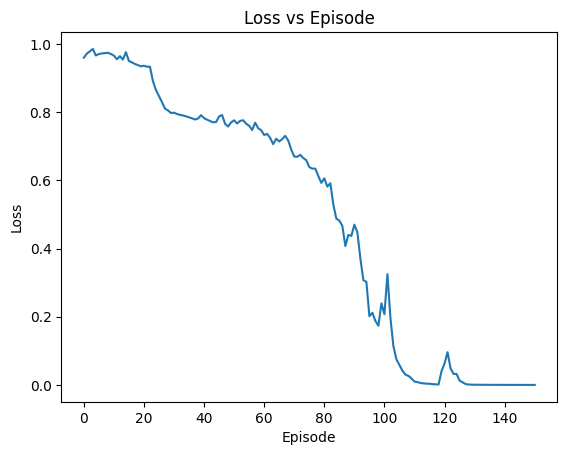

In [28]:
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss vs Episode')
plt.show()